In [1]:
import glob
import numpy as np
import os
import shutil

In [2]:
np.random.seed(42)

### Building Datasets

In [6]:
files = glob.glob('../data/dogs-vs-cats/train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(25000, 25000)

In [7]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [ ]:
train_dir = '../data/dogs-vs-cats/training_data'
val_dir = '../data/dogs-vs-cats/validation_data'
test_dir = '../data/dogs-vs-cats/test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

### Preparing Datasets

In [9]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

%matplotlib inline

In [17]:
IMG_DIM = (150, 150)

train_files = glob.glob('../data/dogs-vs-cats/training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[4].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('../data/dogs-vs-cats/validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[4].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (2916, 150, 150, 3) 	Validation dataset shape: (993, 150, 150, 3)


(150, 150, 3)


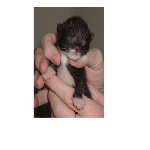

In [18]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [38]:
batch_size = 30
num_classes = 2
epochs = 20
input_shape = (150, 150, 3)

In [20]:
# encode text category labels
from sklearn.preprocessing import LabelEncoder

In [21]:
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat'] [1 0 1 0 1 0 1 1 1 0]


### Simple CNN Model from Scratch

In [28]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential

In [29]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 17, 17, 128)     

In [32]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
98/98 [==============================] - 33s 320ms/step - loss: 0.7475 - accuracy: 0.5117 - val_loss: 0.6795 - val_accuracy: 0.6062
Epoch 2/30
98/98 [==============================] - 32s 330ms/step - loss: 0.6594 - accuracy: 0.6094 - val_loss: 0.6415 - val_accuracy: 0.6606
Epoch 3/30
98/98 [==============================] - 31s 313ms/step - loss: 0.5877 - accuracy: 0.6903 - val_loss: 0.6116 - val_accuracy: 0.6697
Epoch 4/30
98/98 [==============================] - 33s 340ms/step - loss: 0.5038 - accuracy: 0.7521 - val_loss: 0.6091 - val_accuracy: 0.6838
Epoch 5/30
98/98 [==============================] - 32s 330ms/step - loss: 0.4050 - accuracy: 0.8134 - val_loss: 0.6260 - val_accuracy: 0.6939
Epoch 6/30
98/98 [==============================] - 32s 329ms/step - loss: 0.3319 - accuracy: 0.8546 - val_loss: 0.6347 - val_accuracy: 0.7281
Epoch 7/30
98/98 [==============================] - 32s 325ms/step - loss: 0.2368 - accuracy: 0.8975 - val_loss: 0.7108 - val_accuracy: 0.7301

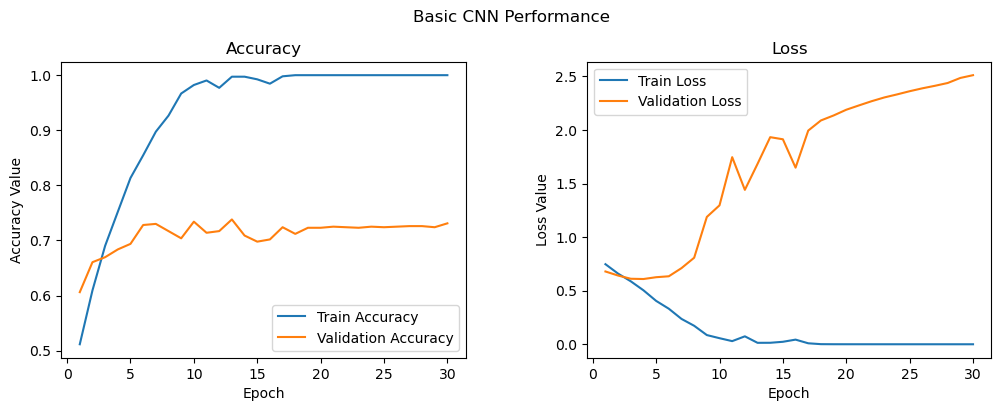

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

### CNN Model with Regularization

In [36]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [37]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [39]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Epoch 1/20
98/98 [==============================] - 28s 284ms/step - loss: 0.6932 - accuracy: 0.5243 - val_loss: 0.6798 - val_accuracy: 0.5257
Epoch 2/20
98/98 [==============================] - 27s 274ms/step - loss: 0.6689 - accuracy: 0.6077 - val_loss: 0.6531 - val_accuracy: 0.6153
Epoch 3/20
98/98 [==============================] - 28s 282ms/step - loss: 0.6255 - accuracy: 0.6588 - val_loss: 0.5883 - val_accuracy: 0.6888
Epoch 4/20
98/98 [==============================] - 27s 273ms/step - loss: 0.5800 - accuracy: 0.6948 - val_loss: 0.5656 - val_accuracy: 0.6898
Epoch 5/20
98/98 [==============================] - 27s 277ms/step - loss: 0.5196 - accuracy: 0.7383 - val_loss: 0.5600 - val_accuracy: 0.7291
Epoch 6/20
98/98 [==============================] - 28s 288ms/step - loss: 0.4623 - accuracy: 0.7798 - val_loss: 0.5117 - val_accuracy: 0.7442
Epoch 7/20
98/98 [==============================] - 31s 315ms/step - loss: 0.4051 - accuracy: 0.8138 - val_loss: 0.5239 - val_accuracy: 0.7492

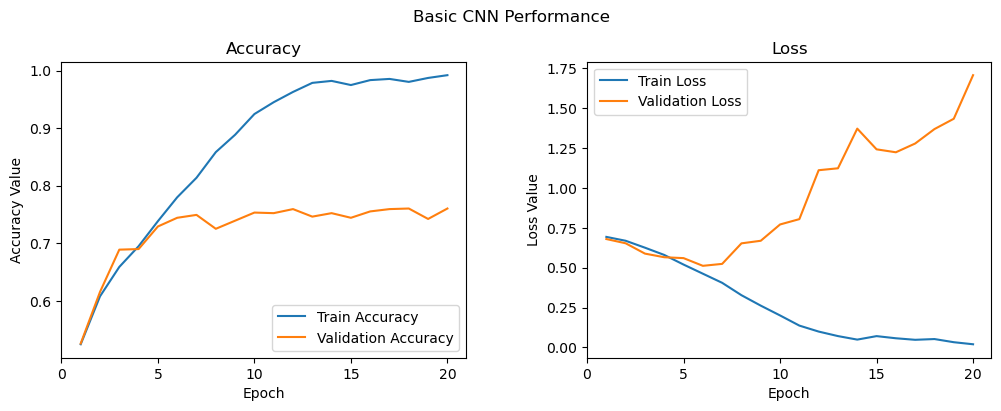

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [47]:
model.save('models/cats_dogs_basic_cnn.h5')

### CNN Model with Image Augmentation

In [48]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


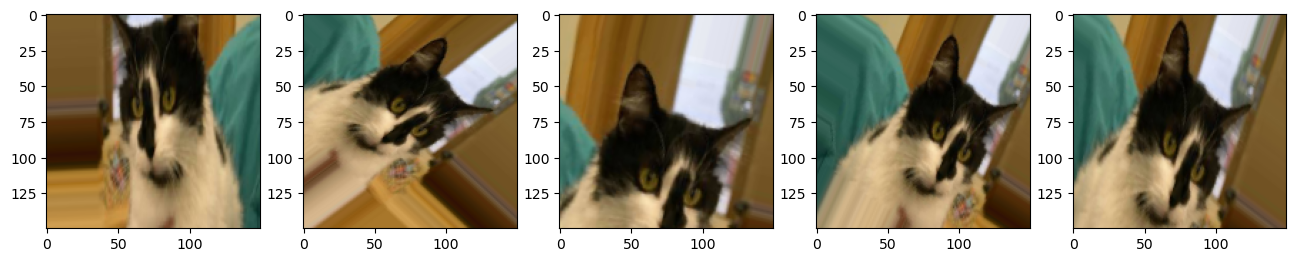

In [55]:
img_id = 1500
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


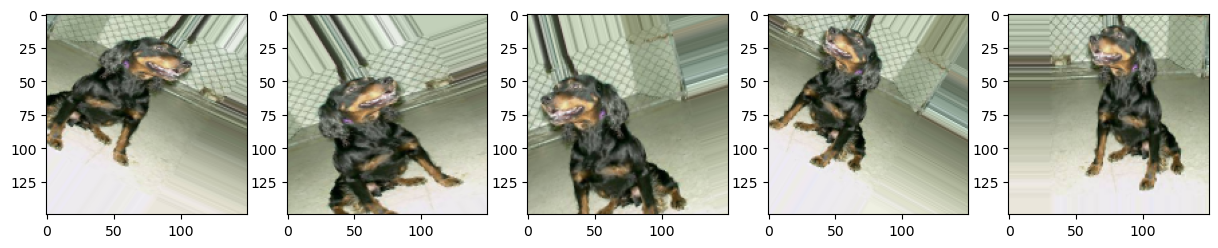

In [57]:
img_id = 2500
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [58]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

In [59]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [60]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
history = model.fit(train_generator, steps_per_epoch=95, epochs=100,
                              validation_data=val_generator, validation_steps=45, 
                              verbose=1)

Epoch 1/100
95/95 [==============================] - 27s 285ms/step - loss: 0.6853 - accuracy: 0.5587 - val_loss: 0.6841 - val_accuracy: 0.5778
Epoch 2/100
95/95 [==============================] - 28s 294ms/step - loss: 0.6911 - accuracy: 0.5230 - val_loss: 0.6893 - val_accuracy: 0.5456
Epoch 3/100
95/95 [==============================] - 29s 303ms/step - loss: 0.6863 - accuracy: 0.5425 - val_loss: 0.6806 - val_accuracy: 0.5856
Epoch 4/100
95/95 [==============================] - 28s 294ms/step - loss: 0.6900 - accuracy: 0.5322 - val_loss: 0.6881 - val_accuracy: 0.5744
Epoch 5/100
95/95 [==============================] - 31s 328ms/step - loss: 0.6852 - accuracy: 0.5517 - val_loss: 0.6795 - val_accuracy: 0.5744
Epoch 6/100
95/95 [==============================] - 30s 314ms/step - loss: 0.6793 - accuracy: 0.5722 - val_loss: 0.6752 - val_accuracy: 0.6011
Epoch 7/100
95/95 [==============================] - 29s 301ms/step - loss: 0.6779 - accuracy: 0.5764 - val_loss: 0.6959 - val_accuracy:

95/95 [==============================] - 29s 299ms/step - loss: 0.4599 - accuracy: 0.7849 - val_loss: 0.4225 - val_accuracy: 0.8133
Epoch 58/100
95/95 [==============================] - 27s 288ms/step - loss: 0.4521 - accuracy: 0.7859 - val_loss: 0.4044 - val_accuracy: 0.8222
Epoch 59/100
95/95 [==============================] - 27s 282ms/step - loss: 0.4531 - accuracy: 0.7887 - val_loss: 0.4090 - val_accuracy: 0.8144
Epoch 60/100
95/95 [==============================] - 27s 288ms/step - loss: 0.4487 - accuracy: 0.7887 - val_loss: 0.3751 - val_accuracy: 0.8311
Epoch 61/100
95/95 [==============================] - 28s 295ms/step - loss: 0.4416 - accuracy: 0.7933 - val_loss: 0.3542 - val_accuracy: 0.8367
Epoch 62/100
95/95 [==============================] - 28s 290ms/step - loss: 0.4447 - accuracy: 0.7902 - val_loss: 0.3697 - val_accuracy: 0.8311
Epoch 63/100
95/95 [==============================] - 28s 294ms/step - loss: 0.4288 - accuracy: 0.7965 - val_loss: 0.4012 - val_accuracy: 0.832

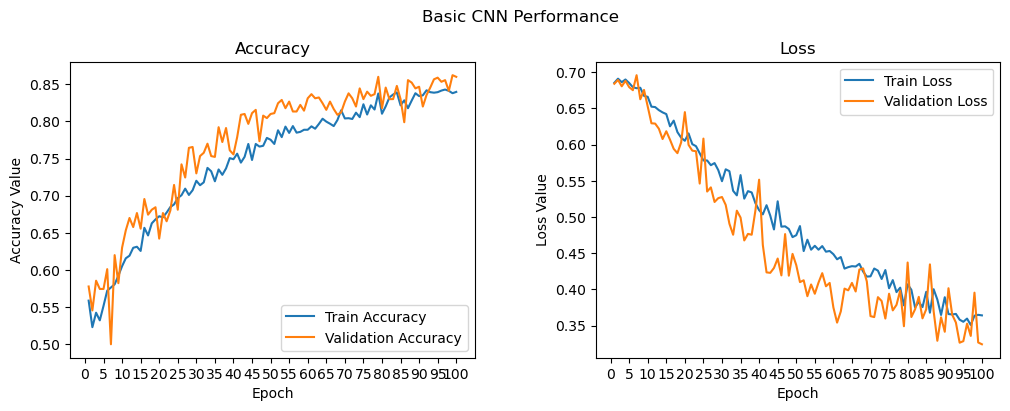

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [66]:
model.save('models/cats_dogs_cnn_img_aug.h5')

### Leveraging Transfer Learning with Pre-trained CNN Models